### 第7章: 機械学習

本章では、Stanford Sentiment Treebank (SST) データセットを用い、評判分析器（ポジネガ分類器）を構築する。ここでは処理を簡略化するため、General Language Understanding Evaluation (GLUE) ベンチマークで配布されているSSTデータセットを用いる。

In [2]:
"""
60. データの入手・整形
GLUEのウェブサイトからSST-2データセットを取得せよ。
学習データ（train.tsv）と検証データ（dev.tsv）のぞれぞれについて、ポジティブ (1) とネガティブ (0) の事例数をカウントせよ。
"""
import pandas as pd
train_df = pd.read_csv("SST-2/train.tsv", sep="\t")
dev_df = pd.read_csv("SST-2/dev.tsv", sep="\t")

for name, df in zip(["train", "dev"], [train_df, dev_df]):
    count_1 = (df['label'] == 1).sum()
    count_0 = (df['label'] == 0).sum()

    print(f"{name}")
    print(f" ポジティブ: {count_1}, ネガティブ: {count_0}")


train
 ポジティブ: 37569, ネガティブ: 29780
dev
 ポジティブ: 444, ネガティブ: 428


In [3]:
"""
61. 特徴ベクトル
Bag of Words (BoW) に基づき、学習データ（train.tsv）および検証データ（dev.tsv）のテキストを特徴ベクトルに変換したい。
ここで、ある事例のテキストの特徴ベクトルは、テキスト中に含まれる単語（スペース区切りのトークン）の出現頻度で構成する。

例えば、”too loud , too goofy”というテキストに対応する特徴ベクトルは、以下のような辞書オブジェクトで表現される。
{'too': 2, 'loud': 1, ',': 1, 'goofy': 1}

各事例はテキスト、特徴ベクトル、ラベルを格納した辞書オブジェクトでまとめておく。

例えば、先ほどの”too loud , too goofy”に対してラベル”0”（ネガティブ）が付与された事例は、以下のオブジェクトで表現される。
{'text': 'too loud , too goofy', 'label': '0', 'feature': {'too': 2, 'loud': 1, ',': 1, 'goofy': 1}}

学習データと検証データの各事例を上記のような辞書オブジェクトに変換したうえで、
学習データと検証データのそれぞれを、辞書オブジェクトのリストとして表現せよ。
さらに、学習データの最初の事例について、正しく特徴ベクトルに変換できたか、目視で確認せよ。
"""
from collections import Counter

def text_to_bec(df):
    dct_lst = []
    for _, row in df.iterrows():
        sentence = row["sentence"]
        label = row["label"]

        words = sentence.split()
        counter = Counter(words)
        feature = dict(counter)    

        dct_lst.append({'text':sentence,
               'label':label,
               'feature': feature
        })
        
    return dct_lst

train_list  = text_to_bec(train_df)
dev_list = text_to_bec(dev_df)
print(train_list[0])


{'text': 'hide new secretions from the parental units ', 'label': 0, 'feature': {'hide': 1, 'new': 1, 'secretions': 1, 'from': 1, 'the': 1, 'parental': 1, 'units': 1}}


In [4]:
"""
62. 学習
61で構築した学習データの特徴ベクトルを用いて、ロジスティック回帰モデルを学習せよ。
"""
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer()
train_features = [dct["feature"] for dct in train_list]
train_x = vectorizer.fit_transform(train_features)
train_y = [dct["label"] for dct in train_list]


from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="lbfgs",max_iter=10000,random_state=123)
lr.fit(train_x, train_y)


LogisticRegression(max_iter=10000, random_state=123)

In [5]:
"""
63. 予測
学習したロジスティック回帰モデルを用い、検証データの先頭の事例のラベル（ポジネガ）を予測せよ。
また、予測されたラベルが検証データで付与されていたラベルと一致しているか、確認せよ。
"""
dev_features = [dct['feature'] for dct in dev_list]
dev_x = vectorizer.transform(dev_features)
dev_y = [dct['label'] for dct in dev_list]

train_preds = lr.predict(train_x)
dev_preds = lr.predict(dev_x)

from sklearn.metrics import accuracy_score
train_acc = accuracy_score(train_preds, train_y)
dev_acc = accuracy_score(dev_preds, dev_y)

print(f"正解率（学習データ）：{train_acc}")
print(f"正解率（検証データ）：{dev_acc}")

正解率（学習データ）：0.9418254168584538
正解率（検証データ）：0.8119266055045872


In [6]:
"""
64. 条件付き確率
学習したロジスティック回帰モデルを用い、検証データの先頭の事例を各ラベル（ポジネガ）に分類するときの条件付き確率を求めよ。
"""
print(lr.predict_proba(dev_x[0]))


[[0.00414111 0.99585889]]


In [7]:
"""
65. テキストのポジネガの予測
与えられたテキストのポジネガを予測するプログラムを実装せよ。
例えば、テキストとして”the worst movie I ‘ve ever seen”を与え、ロジスティック回帰モデルの予測結果を確認せよ。
"""
def pred(text, lr,vectorizer):
    feature = dict(Counter(text.split()))
    x = vectorizer.transform(feature)
    label_map = {0: "ネガティブ", 1: "ポジティブ"}
    print(label_map[lr.predict(x)[0]])

text = "the worst movie I ‘ve ever seen"
pred(text, lr, vectorizer) 

ネガティブ


学習データ


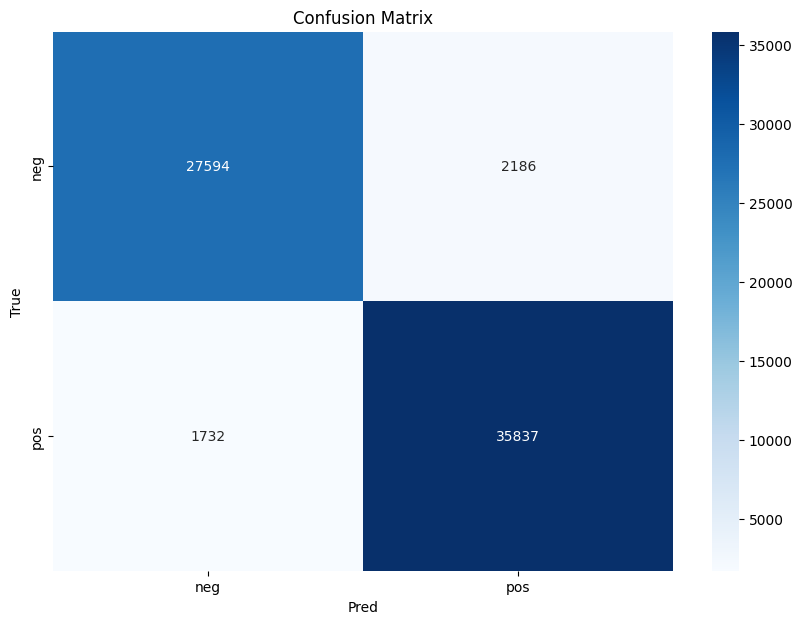

検証データ


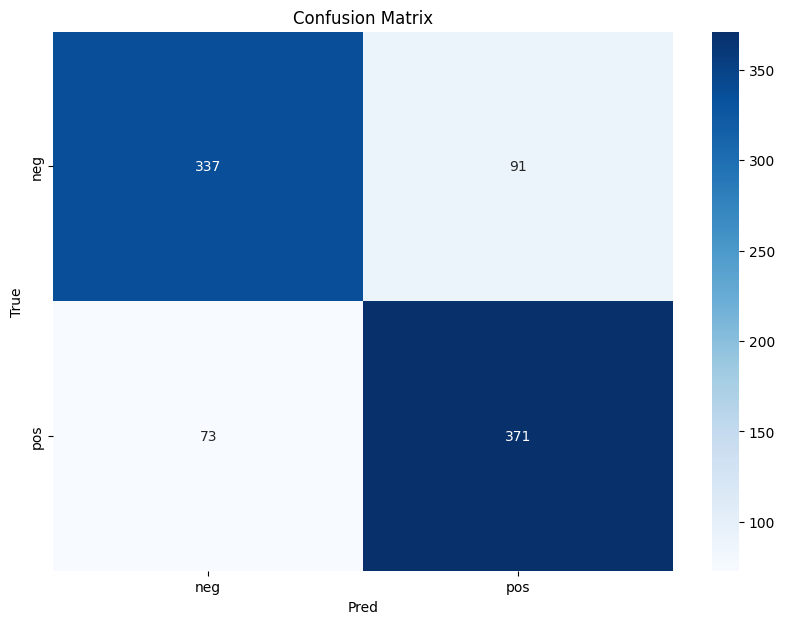

In [8]:
"""
66. 混同行列の作成
学習したロジスティック回帰モデルの検証データにおける混同行列（confusion matrix）を求めよ。
"""
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true, pred):
    confmat = confusion_matrix(y_true=true, y_pred=pred)

    plt.figure(figsize=(10, 7))
    sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["neg", "pos"], 
                yticklabels=["neg", "pos"])
    
    plt.title('Confusion Matrix')
    plt.xlabel('Pred')
    plt.ylabel('True')
    plt.show()

print("学習データ")
plot_confusion_matrix(train_y,train_preds)
print("検証データ")
plot_confusion_matrix(dev_y, dev_preds)


In [9]:
"""
67. 精度の計測
学習したロジスティック回帰モデルの正解率、適合率、再現率、F1スコアを、学習データおよび検証データ上で計測せよ。
"""
from sklearn.metrics import precision_score, recall_score, f1_score

print("学習データ")
print(f" 正解率：{accuracy_score(train_y, train_preds)}")
print(f" 適合率：{precision_score(train_y, train_preds)}")
print(f" 再現率：{recall_score(train_y, train_preds)}")
print(f" F1スコア：{f1_score(train_y, train_preds)}")
print()

print("検証データ")
print(f" 正解率：{accuracy_score(dev_y, dev_preds)}")
print(f" 適合率：{precision_score(dev_y, dev_preds)}")
print(f" 再現率：{recall_score(dev_y, dev_preds)}")
print(f" F1スコア：{f1_score(dev_y, dev_preds)}")
print()



from sklearn.metrics import classification_report
print("学習データ")
print(classification_report(train_y, train_preds, labels=[0, 1]))
print()
print("検証データ")
print(classification_report(dev_y, dev_preds, labels=[0, 1]))
print()

学習データ
 正解率：0.9418254168584538
 適合率：0.9425084817084396
 再現率：0.9538981607176129
 F1スコア：0.9481691184252302

検証データ
 正解率：0.8119266055045872
 適合率：0.803030303030303
 再現率：0.8355855855855856
 F1スコア：0.8189845474613686

学習データ
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     29780
           1       0.94      0.95      0.95     37569

    accuracy                           0.94     67349
   macro avg       0.94      0.94      0.94     67349
weighted avg       0.94      0.94      0.94     67349


検証データ
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       428
           1       0.80      0.84      0.82       444

    accuracy                           0.81       872
   macro avg       0.81      0.81      0.81       872
weighted avg       0.81      0.81      0.81       872




In [10]:
"""
68. 特徴量の重みの確認
学習したロジスティック回帰モデルの中で、重みの高い特徴量トップ20と、重みの低い特徴量トップ20を確認せよ。
"""
import pandas as pd
import numpy as np

feature_names = vectorizer.get_feature_names_out()
weights = lr.coef_[0] 
labels=["neg", "pos"]

weight_df = pd.DataFrame({
    "name":feature_names,
    "weight":weights[0]
})
top_20 = weight_df.nlargest(20,"weight")
print("重みの高い特徴量トップ20")
print(top_20.to_string(index=False))

bottom_20 = weight_df.nsmallest(20,"weight")
print("重みの低い特徴量トップ20")
print(bottom_20.to_string(index=False))
print()

重みの高い特徴量トップ20
name   weight
   ! 0.866571
  !? 0.866571
   # 0.866571
   $ 0.866571
   & 0.866571
   ' 0.866571
  '' 0.866571
'30s 0.866571
'40s 0.866571
'50s 0.866571
 '53 0.866571
'60s 0.866571
'70s 0.866571
'80s 0.866571
'90s 0.866571
  'd 0.866571
 'em 0.866571
 'll 0.866571
  'm 0.866571
  'n 0.866571
重みの低い特徴量トップ20
name   weight
   ! 0.866571
  !? 0.866571
   # 0.866571
   $ 0.866571
   & 0.866571
   ' 0.866571
  '' 0.866571
'30s 0.866571
'40s 0.866571
'50s 0.866571
 '53 0.866571
'60s 0.866571
'70s 0.866571
'80s 0.866571
'90s 0.866571
  'd 0.866571
 'em 0.866571
 'll 0.866571
  'm 0.866571
  'n 0.866571



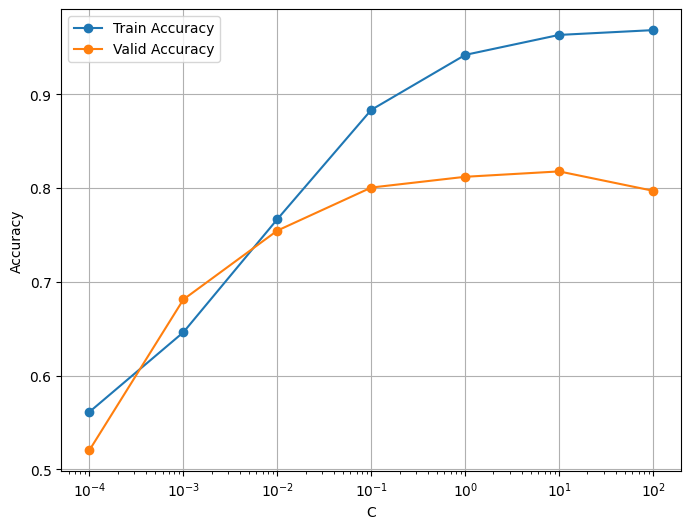

In [11]:
"""
69. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき、正則化の係数（ハイパーパラメータ）を調整することで、学習時の適合度合いを制御できる。
正則化の係数を変化させながらロジスティック回帰モデルを学習し、検証データ上の正解率を求めよ。
実験の結果は、正則化パラメータを横軸、正解率を縦軸としたグラフにまとめよ。
"""
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

C_values = np.logspace(-4, 2, 7, base=10)

train_accs = []
dev_accs = []

for c in C_values:
    lr = LogisticRegression(solver="lbfgs",max_iter=10000,random_state=123,C=c)
    lr.fit(train_x, train_y)

    train_pred = lr.predict(train_x)
    dev_pred = lr.predict(dev_x)

    train_accs.append(accuracy_score(train_y,train_pred))
    dev_accs.append(accuracy_score(dev_y,dev_pred))

plt.figure(figsize=(8,6))
plt.plot(C_values, train_accs, label="Train Accuracy", marker="o", linestyle="-")
plt.plot(C_values, dev_accs, label="Valid Accuracy", marker="o", linestyle="-")

plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
